Import packages

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

Pick file

In [6]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
df = pd.read_parquet(datafile)
df.head()

,timestamp,message,living_in_city,author,has_emoji
0,2022-09-17 16:05:00,Mensen die vnv nog willen chillen?\n,1,eye-catching-wolf,False
1,2022-09-17 16:06:00,Ik ben nog in Haarlem/Amsterdam\n,0,hypnotic-rabbit,False
2,2022-09-17 16:06:00,Sorry man ik heb feestje van familie\n,1,nutty-chough,False
3,2022-09-17 16:21:00,Ai jammer\n,1,eye-catching-wolf,False
4,2022-09-17 16:22:00,Andere gegadigden?\n,1,eye-catching-wolf,False


Length of message

In [7]:
# Calculate the word count for each message
df['word_count'] = df['message'].str.split().str.len()
df.head() 

,timestamp,message,living_in_city,author,has_emoji,word_count
0,2022-09-17 16:05:00,Mensen die vnv nog willen chillen?\n,1,eye-catching-wolf,False,6
1,2022-09-17 16:06:00,Ik ben nog in Haarlem/Amsterdam\n,0,hypnotic-rabbit,False,5
2,2022-09-17 16:06:00,Sorry man ik heb feestje van familie\n,1,nutty-chough,False,7
3,2022-09-17 16:21:00,Ai jammer\n,1,eye-catching-wolf,False,2
4,2022-09-17 16:22:00,Andere gegadigden?\n,1,eye-catching-wolf,False,2


/tmp/ipykernel_3015/953488329.py:3: RuntimeWarning: divide by zero encountered in log
  df["log_len"] = df["word_count"].apply(lambda x: np.log(x))


<Axes: xlabel='log_len', ylabel='Count'>

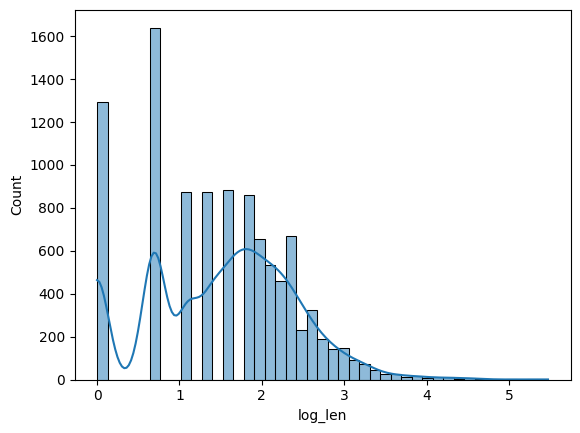

In [8]:
import numpy as np

df["log_len"] = df["word_count"].apply(lambda x: np.log(x))
sns.histplot(df, x="log_len", kde=True)